# Análise de Sentimento com Embeddings Word2Vec e LSTM + CNN



## Tema e relevância

A tarefa de análise sentimento consiste no uso de artifícios de NLP para identificar, extrair, quantificar e estudar informação subjetiva. Por meio da análise de sentimento, buscamos identificar o caráter sentimental contido em um determinado texto, classificando-o de acordo com sua positividade ou negatividade.

A análise de sentimento vê aplicação principalmente na identificação de sentimento em avaliações de produtos e serviços e em comentários em redes sociais. No meio comercial, esta técnica pode ser empregada por organizações para classificar o sentimento dos consumidores, utilizando posteriormente essa informação como material de apoio na elaboração de estratégias de marketing. Além disso, a técnica pode ser utilizada em chatbots e em redes sociais, identificando o caráter sentimental de mensagens e podendo utilizar esse dado posteriormente para análises. 


## Justificativa de escolha do dataset
Tendo em vista as aplicações reais levantadas para a tarefa de análise de sentimento, selecionamos a base dados *Amazon Fine Food Reviews*, fornecida pelo *Stanford Network Analysis Project*. 

A base de dados escolhida para o projeto agrupa uma coleção de avaliações de produtos alimentícios, vendidos na Amazon ao longo de um período mais de 10 anos e conta com mais de 500 mil avaliações.

Cada registro de avaliação contém informação sobre usuário avaliador, nota fornecida (variando de 1 a 5), texto incluído na avaliação, além de outros aspectos sobre a utilidade da avaliação em questão, na perspectiva de outros usuários.


## Justificativa de escolha da solução

Imaginamos que o uso de embeddings word2vec seja um ponto chave para obter um bom desempenho na classificação. Através do uso de vetores densos, os embeddings word2vec, como entrada para o nosso modelo preditivo, podemos obter representações interessantes para os sentimentos, isto é, palavras expressivas para a análise de sentimento. Além disso, podemos obter representações carregadas de semântica contextual, com boas aproximações mesmo para palavras não tão frequentes.

O modelo preditivo implementado consiste em um modelo neural com duas camadas de LSTMs bidirecionais e uma CNN atuando com max pooling. Escolhemos esta arquitetura pra o projeto considerando a capacidade das LSTMs de considerar o contexto em memória para as decisões, juntamente à capacidade da CNN em observar características predominantes nas features, o sentimento. Mais a frente, na seção de predição, detalharemos mais a fundo a arquitetura utilizada.


### Requisitos

Bibliotecas
* `Gensim`
* `Nltk`
* `Keras`
* `Seaborn`
* `SkLearn`
* `bs4`

Link para o corpus:
https://www.kaggle.com/snap/amazon-fine-food-reviews


In [2]:
import pandas as pd

import numpy as np
import multiprocessing
import collections
import re
import os

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, GlobalMaxPool1D, MaxPooling1D, Conv1D, LSTM, Bidirectional
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [4]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Box\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Carregando o dataset

In [6]:
amazon_raw_data = pd.read_csv('./input/Reviews.csv', encoding = "ISO-8859-1")

## Análise dos dados

In [7]:
print("A base de dados contém ",amazon_raw_data.Text.count()," avaliações")

A base de dados contém  568454  avaliações


In [8]:
amazon_raw_data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


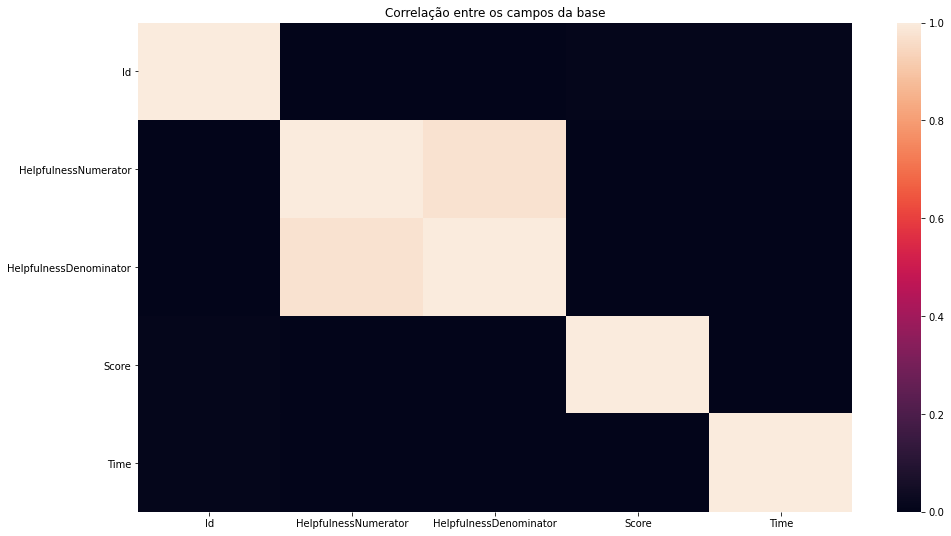

In [9]:
corr = amazon_raw_data.corr()
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax, vmin=0.0, vmax=1.0)
plt.title("Correlação entre os campos da base")
print()

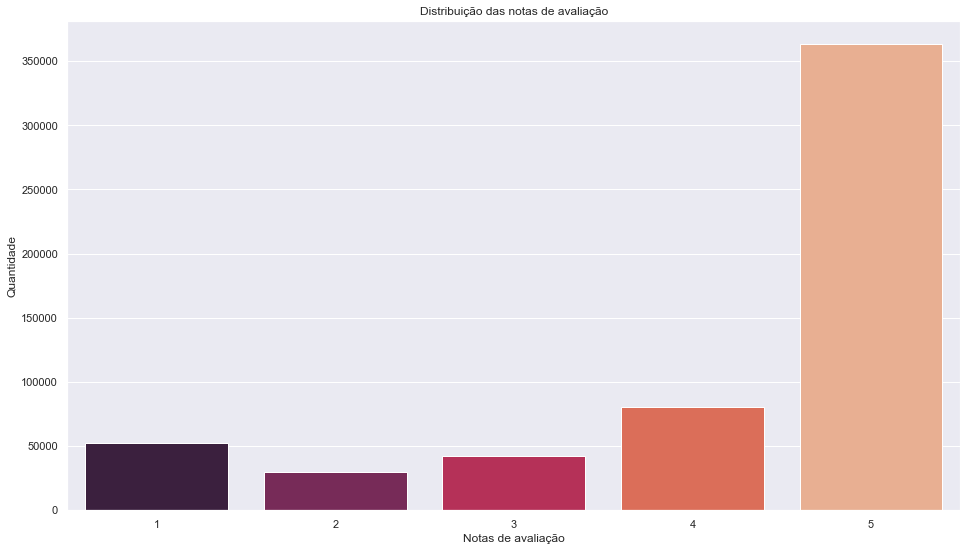

In [10]:
score_count = collections.Counter(amazon_raw_data['Score'])

keys = list(score_count.keys())
vals = [score_count[k] for k in keys]
sns.set(rc={'figure.figsize':(16,9)})
ax = sns.barplot(x=keys, y=vals, palette="rocket")
ax.set_xticklabels(ax.get_xticklabels())
ax.set(xlabel='Notas de avaliação', ylabel='Quantidade')
plt.title("Distribuição das notas de avaliação")
plt.show()

Podemos perceber uma forte desbalanceamento na distribuição de notas de avaliação. Levaremos este aspecto em consideração durante as próximas etapas.

## Pré Processamento

### Removendo colunas desnecessárias

Para a tarefa que vamos realizar, precisaremos apenas da colunas contendo o corpo e a nota da avaliação.

In [11]:
amazon_data = amazon_raw_data[['Text','Score']]

In [12]:
amazon_data.head(5)

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


### Modificando a granularidade das notas

Iremos transformar a situação para classificação binária. Para isso, eliminaremos as avaliações neutras (nota 3) e agruparemos as positivas e negativas em dois grupos, definidos por 1 e 0, respectivamente.

In [13]:
score_dict = {1:0, 2:0, 4:1, 5:1}
amazon_data = amazon_data[amazon_data['Score'] != 3]
amazon_data['pScore'] = amazon_data['Score'].map(score_dict)

2021-03-23 15:02:25,562 : INFO : NumExpr defaulting to 4 threads.


In [14]:
amazon_data.head()

,Text,Score,pScore
0,I have bought several of the Vitality canned d...,5,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,0
2,This is a confection that has been around a fe...,4,1
3,If you are looking for the secret ingredient i...,2,0
4,Great taffy at a great price. There was a wid...,5,1


### Stopwords

In [15]:
stopword_list=stopwords.words('english')

In [16]:
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Como podemos ver, dentro do conjunto de stopwords existem muitos termos que poderiam ser de impacto expressivo na semântica das avaliações. As stopwords, em sua maioria, possuem o papel de negação e isso é extremamente impactante para a aplicação que estamos buscando.

Desta forma, manteremos as stopwords no texto.

### Lower casing,  stemming, expandindo contrações e remoção de ruídos

Como pré processamento do texto, para bons resultados com os embeddings e, consequentemente, com o modelo preditivo, realizaremos as seguintes operações:

- `Lower casing`: todas as palavras em forma minúscula
- `Stemming`: redução de palavras flexionadas ao seu radical
- `Expansão de contrações`: expansão de contrações como *can't* para cannot
- `Remoção de ruídos`: remoção de tags html encontradas dentro do texto

In [17]:
stemmer = SnowballStemmer("english")

In [18]:
contractions = pd.read_csv('./input/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

In [19]:
contractions.head(5)

,Meaning
Contraction,
'aight,alright
ain't,is not
amn't,am not
aren't,are not
can't,cannot


In [20]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def preprocess_text(text, stemming=True, stopwords_removal=False):
    text = strip_html(text).lower()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub('([.,!?()])', r' \1 ', text)
    
    for contraction, replacement in contractions_dict.items():
        text = text.replace(contraction, replacement)
        
    tokens = []
    for token in text.split():
        if stopwords_removal:
            if token in stopword_list:
                continue
        if stemming:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)

In [21]:
list(amazon_data.iloc[[10]]['Text'])

["I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"]

In [22]:
%%time
amazon_data['pText'] = amazon_data['Text'].apply(preprocess_text)

Wall time: 8min 25s


In [23]:
list(amazon_data.iloc[[10]]['pText'])

['i do not know if it is the cactus or the tequila or just the uniqu combin of ingredi , but the flavour of this hot sauc make it one of a kind ! we pick up a bottl onc on a trip we were on and brought it back home with us and were total blown away ! when we realiz that we simpli could not find it anywher in our citi we were bum . now , becaus of the magic of the internet , we have a case of the sauc and are ecstat becaus of it . if you love hot sauc . . i mean realli love hot sauc , but do not want a sauc that tasteless burn your throat , grab a bottl of tequila picant gourmet de inclan . just realiz that onc you tast it , you will never want to use ani other sauc . thank you for the person , incred servic !']

In [24]:
amazon_data.head()

,Text,Score,pScore,pText
0,I have bought several of the Vitality canned d...,5,1,i have bought sever of the vital can dog food ...
1,Product arrived labeled as Jumbo Salted Peanut...,1,0,product arriv label as jumbo salt peanut . . ....
2,This is a confection that has been around a fe...,4,1,this is a confect that has been around a few c...
3,If you are looking for the secret ingredient i...,2,0,if you are look for the secret ingredi in robi...
4,Great taffy at a great price. There was a wid...,5,1,great taffi at a great price . there was a wid...


In [25]:
len(amazon_data)

525814

## Dividindo o dado em conjuntos de treino e teste
Divisão 90 (treino + validação) - 10 (teste)

In [26]:
train_reviews, test_reviews, train_scores, test_scores = train_test_split(amazon_data['pText'], amazon_data['pScore'], test_size=0.1, random_state=5)

In [27]:
print(train_reviews.shape,train_scores.shape)
print(test_reviews.shape,test_scores.shape)

(473232,) (473232,)
(52582,) (52582,)


In [28]:
train_reviews.head()

36392     i purchas the miracl noodl spinach angel hair ...
276543    this is great stuff , all of the pace salsai a...
34530     i start drink coffe at the age of 2 when my gr...
119341    a veri good combin of chocol and chai . great ...
472414    after have to give up coffe , and realli miss ...
Name: pText, dtype: object

In [29]:
train_scores.head()

36392     1
276543    1
34530     1
119341    1
472414    1
Name: pScore, dtype: int64

Como existe um desbalanceamento na distribuição de notas, vamos calcular os pesos das classes para uso posterior

In [30]:
aux = train_scores.value_counts().to_dict()
max_val = aux[max(aux, key=aux.get)]
aux.update((x, max_val/y) for x, y in aux.items())

In [31]:
c_weights = aux

In [32]:
c_weights

{1: 1.0, 0: 5.403593997374866}

## Embeddings com SKIP-GRAM


In [33]:
LOADING_W2V_MODEL = True

In [34]:
%%time
reviews = list(map(lambda x: x.split(), train_reviews))

Wall time: 4.74 s


In [35]:
len(reviews)

473232

In [36]:
W2V_SIZE = 100
W2V_WINDOW = 5
W2V_EPOCH = 16
W2V_MIN_COUNT = 5
W2V_SG = 1
W2V_NEGATIVE = 15

In [37]:
if LOADING_W2V_MODEL:
    w2v_model = Word2Vec.load("./model/100_5_16_5_1_15")      

2021-03-23 15:10:56,298 : INFO : loading Word2Vec object from ./model/100_5_16_5_1_15
2021-03-23 15:10:57,011 : INFO : loading wv recursively from ./model/100_5_16_5_1_15.wv.* with mmap=None
2021-03-23 15:10:57,011 : INFO : setting ignored attribute vectors_norm to None
2021-03-23 15:10:57,011 : INFO : loading vocabulary recursively from ./model/100_5_16_5_1_15.vocabulary.* with mmap=None
2021-03-23 15:10:57,011 : INFO : loading trainables recursively from ./model/100_5_16_5_1_15.trainables.* with mmap=None
2021-03-23 15:10:57,019 : INFO : setting ignored attribute cum_table to None
2021-03-23 15:10:57,019 : INFO : loaded ./model/100_5_16_5_1_15


In [38]:
if not LOADING_W2V_MODEL: 
    w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            sg = W2V_SG,
                                            negative = W2V_NEGATIVE, 
                                            workers=4)

In [39]:
%%time
if not LOADING_W2V_MODEL:
    w2v_model.build_vocab(reviews)

Wall time: 0 ns


In [40]:
%%time
if not LOADING_W2V_MODEL:
    w2v_model.train(reviews, total_examples=len(reviews), epochs=W2V_EPOCH)

Wall time: 0 ns


In [41]:
print(w2v_model.most_similar("best"))
print(w2v_model.most_similar("good"))
print(w2v_model.most_similar("worst"))
print(w2v_model.most_similar("bad"))

2021-03-23 15:10:57,156 : INFO : precomputing L2-norms of word weight vectors


[('tastiest', 0.8330073356628418), ('best-tast', 0.7619049549102783), ('worst', 0.7539272308349609), ('greatest', 0.7495632767677307), ('smoothest', 0.7031363844871521), ('yummiest', 0.7023736834526062), ('finest', 0.6620043516159058), ('nicest', 0.6543007493019104), ('healthiest', 0.6481294631958008), ('easiest', 0.62855064868927)]
[('great', 0.7497071027755737), ('decent', 0.7428554892539978), ('tasti', 0.6635102033615112), ('fantast', 0.6608576774597168), ('bad', 0.6518062353134155), ('nice', 0.6419807076454163), ('yummi', 0.6361426115036011), ('terrif', 0.632636547088623), ('w/cranberri', 0.6222407817840576), ('gooooooood', 0.6161303520202637)]
[('nastiest', 0.8149427175521851), ('best', 0.7539272308349609), ('worst-tast', 0.707737922668457), ('grossest', 0.7064571380615234), ('tastiest', 0.6869831085205078), ('weakest', 0.6775977611541748), ('foulest', 0.6749820113182068), ('greatest', 0.6612563133239746), ('strangest', 0.6391239166259766), ('horrid', 0.6232931017875671)]
[('terri

In [42]:
len(w2v_model.wv.vocab.keys())

43614

In [43]:
word_vectors = w2v_model.wv

In [44]:
# w2v_model.save("./model/"+str(W2V_SIZE)+"_"+str(W2V_WINDOW)+"_"+str(W2V_EPOCH)+"_"+str(W2V_MIN_COUNT)+"_"+str(W2V_SG)+"_"+str(W2V_NEGATIVE))

## Preparação para o modelo preditivo

Limite do tamanho da sequência

In [45]:
SEQUENCE_LENGTH = 100

Tokenizer

In [46]:
%%time
tokenizer = Tokenizer(filters="", oov_token="<oov>")
tokenizer.fit_on_texts(train_reviews)

vocab_size = len(tokenizer.word_index) + 1
print("Tamanho do vocabulário Tokenizer: ", vocab_size)

Tamanho do vocabulário Tokenizer:  192004
Wall time: 24.4 s


Padding

In [47]:
%%time
X_train = pad_sequences(tokenizer.texts_to_sequences(train_reviews), maxlen=SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_reviews), maxlen=SEQUENCE_LENGTH)

Wall time: 22.3 s


In [48]:
print("X_train", X_train.shape)
print("X_test", X_test.shape)

X_train (473232, 100)
X_test (52582, 100)


In [49]:
y_train = np.array(train_scores)
y_test = np.array(test_scores)

In [50]:
print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (473232,)
y_test (52582,)


In [51]:
y_train[:10]

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0], dtype=int64)

In [52]:
def count_ones_zeros(arr):
    z=0
    u=0
    for val in arr:
        if val == 0:
            z+=1
        elif val == 1:
            u+=1
    print("Num. 0s: ", z)
    print("Num. 1s:", u)
    
count_ones_zeros(y_train)
print()
count_ones_zeros(y_test)

Num. 0s:  73901
Num. 1s: 399331

Num. 0s:  8136
Num. 1s: 44446


Embedding Matrix

In [53]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [54]:
print(embedding_matrix.shape)

(192004, 100)


## Modelo preditivo
Para a predição de sentimento, utilizaremos um modelo formado por duas camadas de LSTMs bidirecionais, além de uma CNN com max pooling.

- Uma camada de embeddings para que possamos utilizar nossos word2vec como entrada.
- Duas camadas de LSTMs bidirecionais
- Uma CNN para texto com janela deslizante de tamanho 5
- Uma camada para o max pooling
- Uma densa com ativação ReLU (max(0,x))
- Uma densa com ativação sigmoid (classificação binária)


In [55]:
model_name = "BI-LSTM-CONV"

In [56]:
def build_model():
    embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ],
    name= model_name)
    return model

In [57]:
model = build_model()

In [58]:
model.summary()

Model: "BI-LSTM-CONV"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          19200400  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          240800    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 100)           100100    
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

Utilizaremos:
- otimizador *Adam* para a descida de gradiente
- função de perda *binary crossentropy*, considerando a natureza do problema 
- métrica de acurácia

In [59]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Os callbacks auxiliarão o treinamento do modelo, diminuindo o *learning rate* de acordo com a perda de avaliação e efetuando o *early stopping* caso a acurácia de validação não suba por um dado número de épocas.

In [60]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=4, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=4)]

### Treino


In [61]:
EPOCHS = 10
# BATCH_SIZE = 64
BATCH_SIZE = 1024

Aplicaremos então os pesos das classes no treino, como forma de compensar o desbalanceamento na distribuição das classes 0 e 1.
A classe 0 receberá um peso maior e, dessa forma, será possível evitar que o modelo caia em solução trivial.

In [62]:
c_weights

{1: 1.0, 0: 5.403593997374866}

In [63]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    class_weight=c_weights,
                    callbacks=callbacks)

Epoch 1/10
416/416 [==============================] - 146s 283ms/step - loss: 0.6760 - accuracy: 0.8123 - val_loss: 0.2494 - val_accuracy: 0.8953
Epoch 2/10
416/416 [==============================] - 116s 278ms/step - loss: 0.4316 - accuracy: 0.8879 - val_loss: 0.2071 - val_accuracy: 0.9122
Epoch 3/10
416/416 [==============================] - 115s 276ms/step - loss: 0.3662 - accuracy: 0.9061 - val_loss: 0.1579 - val_accuracy: 0.9379
Epoch 4/10
416/416 [==============================] - 114s 273ms/step - loss: 0.3298 - accuracy: 0.9177 - val_loss: 0.2020 - val_accuracy: 0.9186
Epoch 5/10
416/416 [==============================] - 143s 345ms/step - loss: 0.3107 - accuracy: 0.9217 - val_loss: 0.1376 - val_accuracy: 0.9454
Epoch 6/10
416/416 [==============================] - 186s 447ms/step - loss: 0.2884 - accuracy: 0.9278 - val_loss: 0.1775 - val_accuracy: 0.9271
Epoch 7/10
416/416 [==============================] - 271s 652ms/step - loss: 0.2708 - accuracy: 0.9310 - val_loss: 0.1231 -

In [64]:
# model.save(model_name)

In [66]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

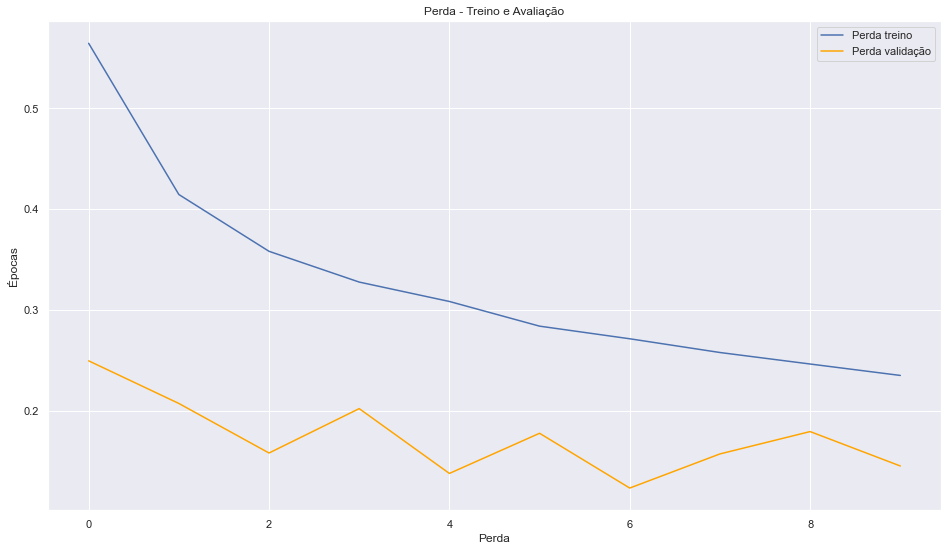

In [108]:
plt.title('Perda - Treino e Avaliação')
ax = sns.lineplot(epochs, loss,  label='Perda treino')
ax.set(xlabel='Perda', ylabel='Épocas')
plt.plot(epochs, val_loss, 'orange', label='Perda validação')
plt.legend()
plt.show()

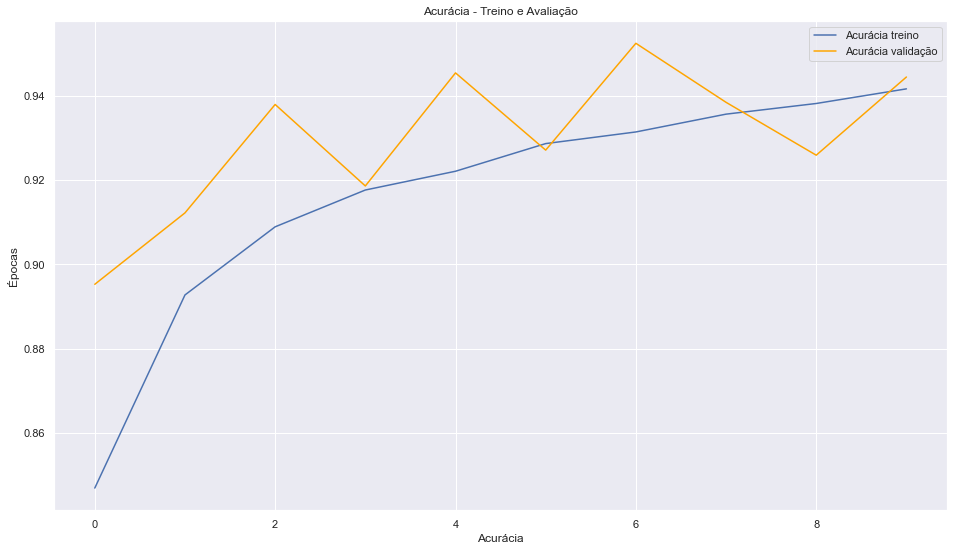

In [109]:
plt.title('Acurácia - Treino e Avaliação')
ax = sns.lineplot(epochs, acc,  label='Acurácia treino')
ax.set(xlabel='Acurácia', ylabel='Épocas')
plt.plot(epochs, val_acc, 'orange', label='Acurácia validação')
plt.legend()
plt.show()

### Teste

In [80]:
%%time
score = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

52/52 [==============================] - 5s 96ms/step - loss: 0.1444 - accuracy: 0.9436

ACCURACY: 0.9436308741569519
LOSS: 0.1443701833486557
Wall time: 5.08 s


In [70]:
y_pred = model.predict_classes(X_test)

In [82]:
class_hits = {0:0, 1:0}
class_total = {0:0, 1:0}
for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        class_hits[y_pred[i][0]]+=1
    class_total[y_test[i]]+=1

In [83]:
print(class_hits)
print(class_total)

{0: 7809, 1: 41809}
{0: 8136, 1: 44446}


In [110]:
print("Acurácia em positivos :", class_hits[1]/class_total[1])
print("Acurácia em negativos :", class_hits[0]/class_total[0])

Acurácia em positivos : 0.9406695765648202
Acurácia em negativos : 0.9598082595870207
